## Лабораторная работа №3

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [21]:
df = pd.read_csv('../datasets/insurance_train.csv')
df_test = pd.read_csv('../datasets/insurance_test.csv')

In [22]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [23]:
print(df.describe())

              age         bmi    children       charges
count  338.000000  338.000000  338.000000    338.000000
mean    38.810651   30.672751    1.153846  14092.861924
std     13.637734    6.309709    1.205822  12792.472722
min     18.000000   17.290000    0.000000   1121.873900
25%     27.000000   26.053750    0.000000   4811.304137
50%     38.000000   30.065000    1.000000   9891.530425
75%     50.000000   34.595000    2.000000  19423.699050
max     64.000000   53.130000    5.000000  63770.428010


In [24]:
le = LabelEncoder()
categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
    df_test[col] = le.fit_transform(df_test[col])
df.head()

,age,sex,bmi,children,smoker,region,charges
0,26,1,27.060,0,1,2,17043.34140
1,58,1,36.955,2,1,1,47496.49445
2,20,0,24.420,0,1,2,26125.67477
3,51,0,38.060,0,1,2,44400.40640
4,62,0,25.000,0,0,3,13451.12200


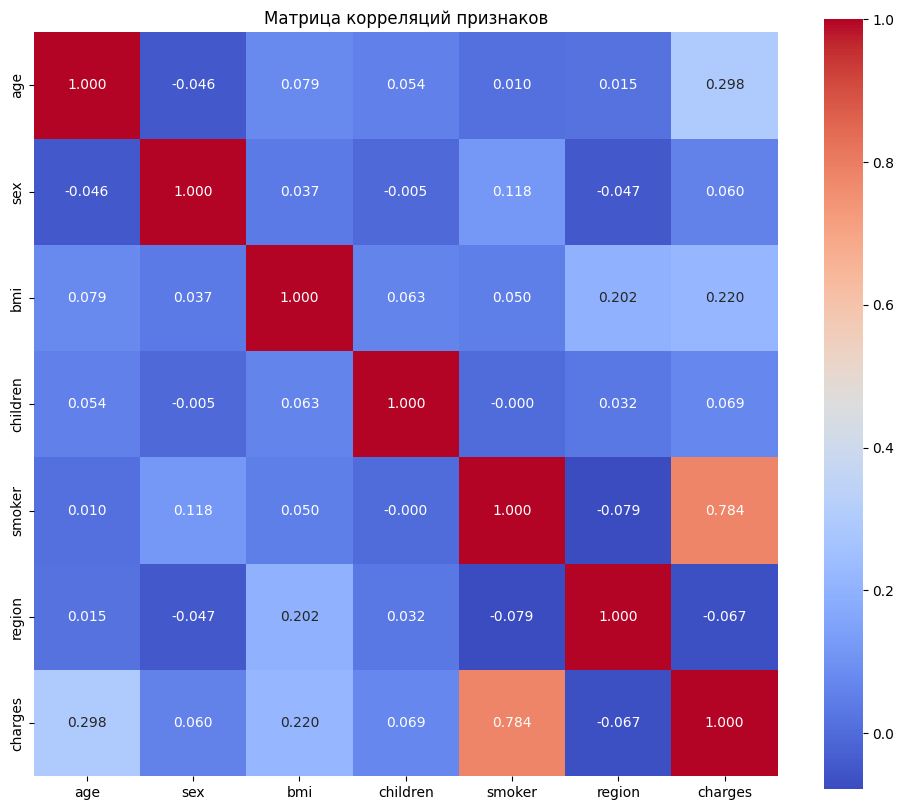

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".3f", square=True)
plt.title("Матрица корреляций признаков")
plt.show()

In [26]:
X = df.drop('charges', axis=1).values
y = df['charges'].values
 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_scaled_f = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled] 
def analytical_solution(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

weights_analytical = analytical_solution(X_scaled_f, y)
print(weights_analytical)

[14092.8619242   3504.4822948   -334.27116556  2134.10856071
   580.89252094  9859.2019211   -594.56924382]


[14092.22530247  3504.44242254  -333.72475989  2134.54235319
   580.91440915  9858.29512479  -595.05622435]


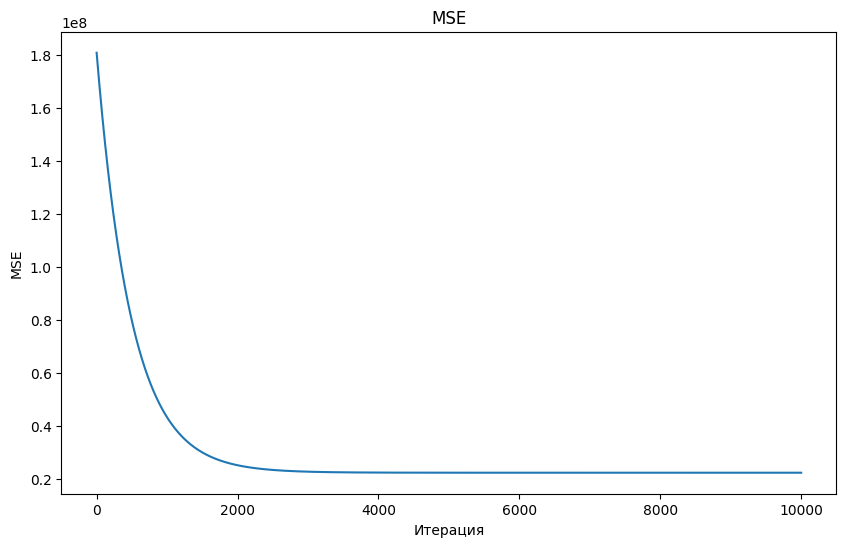

In [27]:
def gradient_descent_scaled(X, y, lr=0.001, n_iterations=10000):
    n = X.shape[0]
    weights = np.zeros(X.shape[1])
    cost_history = []
    for i in range(n_iterations):
        y_pred = X @ weights
        gradient = (1/n) * X.T @ (y_pred - y)
        weights -= lr * gradient
        cost = (1/(2*n)) * np.sum((y_pred - y)**2)
        cost_history.append(cost) 
    return weights, cost_history

weights_gd_scaled, cost = gradient_descent_scaled(X_scaled_f, y)
print(weights_gd_scaled)
plt.figure(figsize=(10, 6))
plt.plot(range(10000), cost)
plt.title('MSE')
plt.xlabel('Итерация')
plt.ylabel('MSE')
plt.show()

In [28]:
def ridge_analytical(X, y, alpha):
    n, m = X.shape
    I = np.identity(m)
    I[0, 0] = 0
    return np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y
weights_ridge = ridge_analytical(X_scaled_f, y, alpha=100)
print(weights_ridge)

[14092.8619242   2756.89224783   -66.94601525  1763.06394354
   496.602066    7608.72759492  -517.19154857]


[14092.8619242   2756.89224783   -66.94601525  1763.06394354
   496.602066    7608.72759492  -517.19154857]


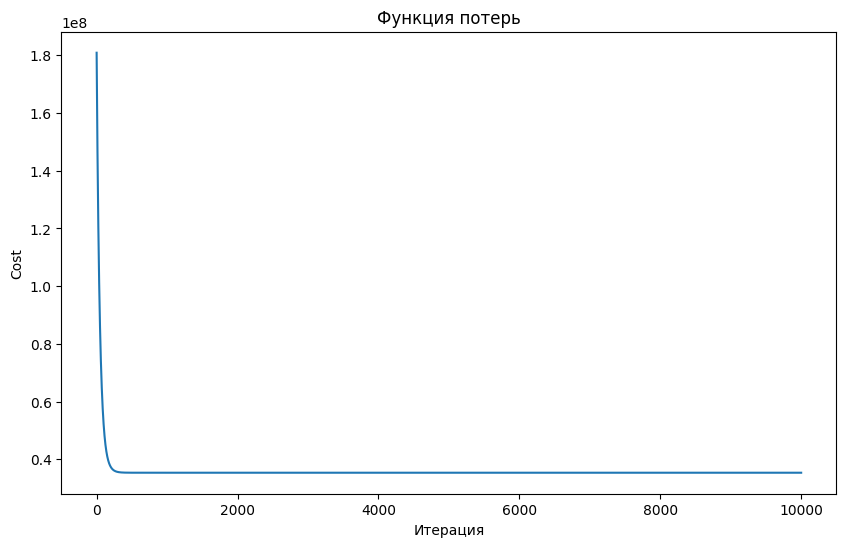

In [29]:
def ridge_gradient(X, y, alpha=1.0, lr=0.01, n_iterations=10000):
    n = X.shape[0]
    weights = np.zeros(X.shape[1])
    cost_history = []
    for i in range(n_iterations):
        y_pred = X @ weights
        reg_penalty = np.zeros_like(weights)
        reg_penalty[1:] = (alpha/n) * weights[1:]
        
        gradient = (1/n) * X.T @ (y_pred - y) + reg_penalty
        weights -= lr * gradient
        mse_cost = (1/(2*n)) * np.sum((y_pred - y)**2)
        reg_cost = (alpha/(2*n)) * np.sum(weights[1:]**2)
        total_cost = mse_cost + reg_cost
        cost_history.append(total_cost)
    return weights, cost_history

weights_ridge_gd, cost = ridge_gradient(X_scaled_f, y, alpha=100)
print(weights_ridge_gd)
plt.figure(figsize=(10, 6))
plt.plot(range(10000), cost)
plt.title('Функция потерь')
plt.xlabel('Итерация')
plt.ylabel('Cost')
plt.show()


In [30]:
X_test = df_test.drop('charges', axis=1).values
y_test = df_test['charges'].values
 
scaler = StandardScaler()
X_scaled_test = scaler.fit_transform(X_test) 
X_scaled_test_f = np.c_[np.ones((X_scaled_test.shape[0], 1)), X_scaled_test] 

In [31]:
results = {}

mean_charge = y.mean()
y_pred_const = np.full_like(y_test, fill_value=mean_charge)
mse_const = mean_squared_error(y_test, y_pred_const)
results['Константная модель'] = mse_const

y_pred_linear = X_scaled_test_f.dot(weights_analytical)
mse_linear = mean_squared_error(y_test, y_pred_linear)
results['Линейная регрессия'] = mse_linear

y_pred_ridge = X_scaled_test_f.dot(weights_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
results['Регрессия L2'] = mse_ridge

results_df = pd.DataFrame(list(results.items()), columns=['Модель', 'MSE на тесте'])
display(results_df)

,Модель,MSE на тесте
0,Константная модель,1.418301e+08
1,Линейная регрессия,3.530690e+07
2,Регрессия L2,3.947529e+07
